In [1]:
import sys
import os
import pickle
import numpy as np
from sklearn import model_selection,preprocessing
from keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.regularizers import l1,l2, l1_l2
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from database import Database
from sample import Sample

Using TensorFlow backend.


In [2]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_database = Database(dataset_loc, database_loc, site)

In [22]:
def train_test_split(test_size, random_state):
    X, y = my_database.load_cuts_db_mp()
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test
    #     return np.array(X_train, dtype=np.float32), np.array(X_test, dtype=np.float32), np.array(y_train, dtype=np.bool_), np.array(y_test, dtype=np.bool_)

In [23]:
# load data
X_train, X_test, y_train, y_test = train_test_split(test_size=0.33, random_state=42)
# reshape for scaler
shape = X_train[-1].shape
X_train = X_train.reshape((len(X_train), shape[0]*shape[1]))
# scale data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# reshape for CNN
X_train = X_train.reshape((len(X_train),1, shape[0], shape[1]))
y_train = np_utils.to_categorical(y_train)
print(X_train.shape, y_train.shape)

100%|██████████| 27004/27004 [00:12<00:00, 2176.78it/s]


(18092, 1, 128, 207) (18092, 2)


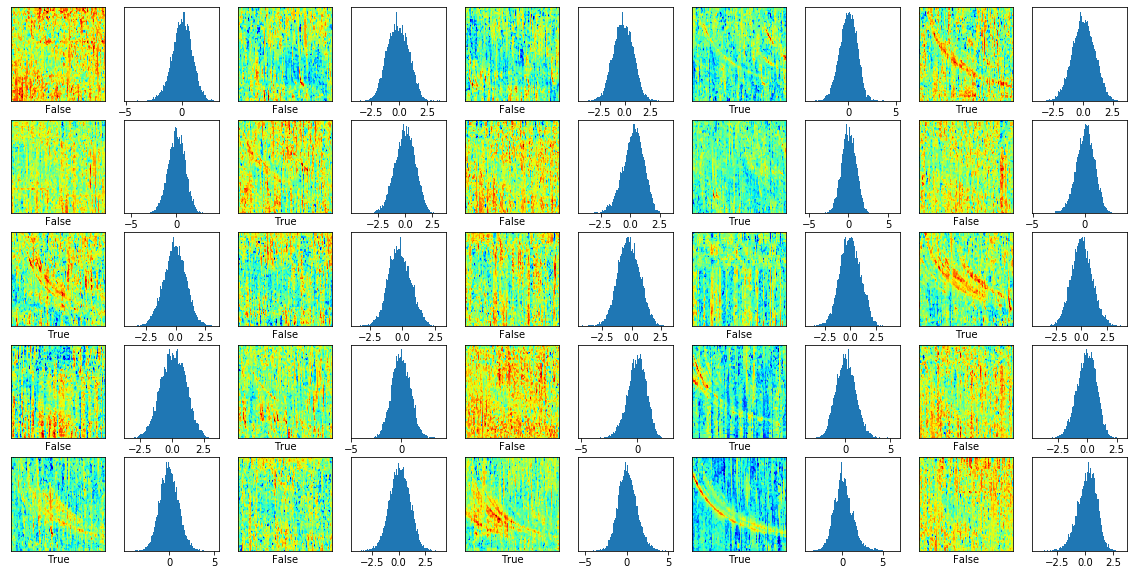

In [24]:
plt.figure(figsize=(10*2,10))
for i in range(0,25*2,2):
    k = np.random.randint(len(X_train))
    plt.subplot(5,5*2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(X_train[i][0], cmap='jet')
    plt.xlabel(np.bool_(y_train[i][1]))    
    plt.subplot(5,5*2,i+2)
    plt.yticks([])
    plt.grid(False)
    plt.hist(X_train[i][0].flatten(), bins='auto')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 2, 128, 207)       244       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 128, 207)       396       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 128, 207)       296       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 2, 128, 207)       16386     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 64, 103)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 13184)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               6750720   
__________

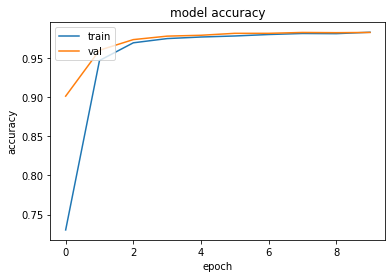

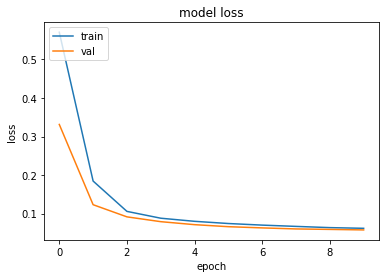

In [25]:
# create the model
model = Sequential()
model.add(Conv2D(2,(11,11), input_shape=(1,shape[0], shape[1]),
                    padding='same', activation='relu',data_format='channels_first'))
# model.add(Dropout(0.9))
model.add(Conv2D(4, (7,7), activation='relu', padding='same',data_format='channels_first'))
# model.add(Dropout(0.9))
model.add(Conv2D(8, (3,3), activation='relu', padding='same',data_format='channels_first'))
model.add(Conv2D(2, (32,32), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.9))
model.add(Dense(2, activation='softmax'))

# compile model
epochs = 25
lrate = 0.0001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=250, shuffle=True)

print(history.history.keys())
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# model.save('cnn.h5')

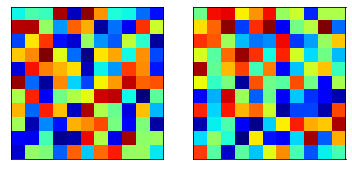

In [26]:
def model_get_conv_layers(model):
    layers = []
    # summarize filter shapes
    for layer in model.layers:
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # get filter weights
        layers.append(layer)
    return layers

def model_visualization(model, summary=False, plot=False, conv_layer_number=0):
    '''Visualize the CNN model'''
    if summary:
        print(model.summary())
    if plot:
        plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
        Image(retina=True, filename='model.png')
    # get filers and biases
    filters, biases = model_get_conv_layers(model)[conv_layer_number].get_weights()
    # scale filters
    f_min, f_max = filters.min(), filters.max()
    filters = (filters-f_min)/(f_max-f_min)
    # get number of filters
    n_filters, ix = filters.shape[-1], 1

    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        # plot each channel seperately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(1,n_filters, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='jet')
            ix += 1
    plt.show()
    
def model_visualization_fm(model, data, conv_layer_number=0):
    feature_maps = model.predict(data)
    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        # plot each channel seperately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(1,n_filters, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.pcolormesh(f[:, :, j], cmap='jet')
            ix += 1
    plt.show()
    
model_visualization(model, conv_layer_number=0)

2013-05-26UT12:49:16.31142156.marion.vr2


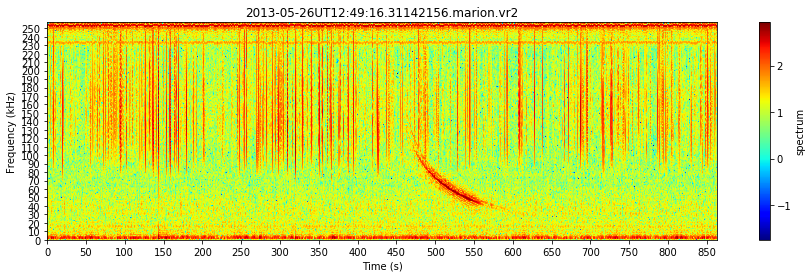

4 1


NameError: name 'spectrogram_reshape' is not defined

In [3]:
my_dataset = Dataset(dataset_loc, site)
my_sample = Sample(dataset_loc, site, my_dataset.get_random_sample())

print(my_sample.get_file())
size=(15,4)
my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())

cuts, _, _ = my_sample.cuts()
# plot results of model on cut

# plot new spec
spec, indices, cuts = my_sample.split(4,1)
my_sample.spectrogram_plot(figsize=size, spec=spec, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())
